# Custom Neural Network - Phase 2

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import sys
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers, callbacks

In [2]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Is GPU available? {tf.test.is_gpu_available()}")
print(f"Available GPUs: {tf.config.list_physical_devices('GPU')}")

# Simple test
x = tf.random.normal((1000, 1000))
y = tf.random.normal((1000, 1000))
z = tf.matmul(x, y)
print(f"Matrix multiplication completed on: {z.device}")

TensorFlow version: 2.18.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? False
Available GPUs: []
Matrix multiplication completed on: /job:localhost/replica:0/task:0/device:CPU:0


### Parameters

In [3]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
PATH_TO_DATASET = '../datasets'
NUM_CLASSES = 3
NUM_EPOCHS = 30

### Import the data and assertions

In [4]:
train_ds = image_dataset_from_directory(f"{PATH_TO_DATASET}/train", labels='inferred', batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_ds = image_dataset_from_directory(f"{PATH_TO_DATASET}/test", labels='inferred', batch_size=BATCH_SIZE, image_size=IMG_SIZE)
CLASSES = train_ds.class_names

print(f"Found classes: {train_ds.class_names}")

assert len(train_ds.class_names) == len(test_ds.class_names) == NUM_CLASSES, f"Train and Test classes should be equal to {NUM_CLASSES}"
assert train_ds.class_names == test_ds.class_names, "Train and Test classes should be the same"

!find ../datasets/ -maxdepth 2 -type d -exec \
  /bin/sh -c 'find {} -type f | \
    echo "$(echo {} | cut -d'/' -f4,5): $(wc -l)" ' \;

Found 8724 files belonging to 3 classes.
Found 2157 files belonging to 3 classes.
Found classes: ['hand', 'low_qual', 'normal']
"$(echo {} | cut -d'/' -f4,5): $(wc -l)" ' \;


FIND: Invalid switch


### Display examples

height: 128, width: 128, channels: 3


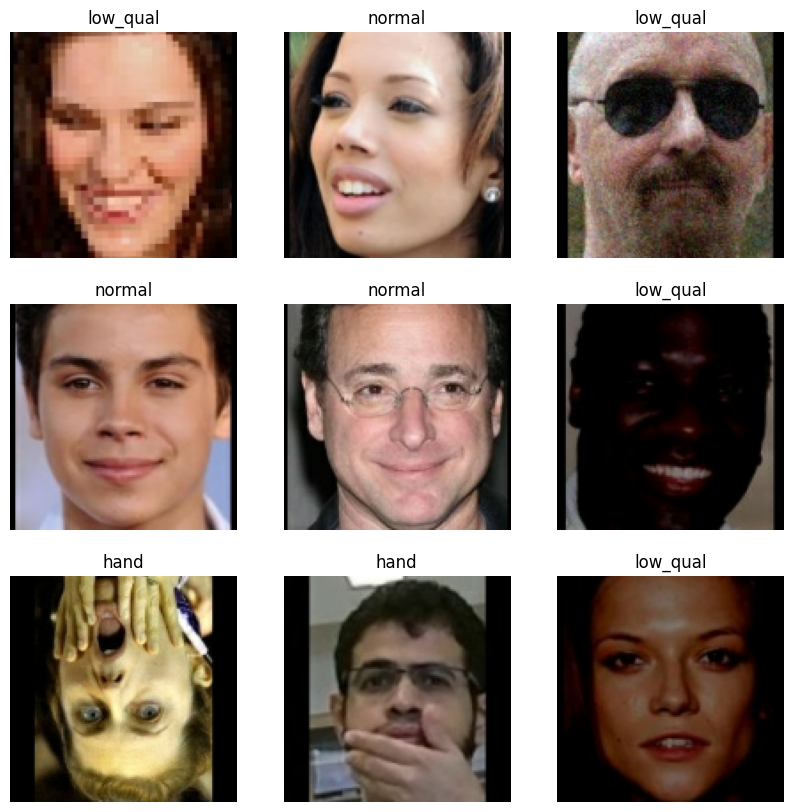

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")
print(f"height: {images.shape[1]}, width: {images.shape[2]}, channels: {images.shape[3]}")

### Normalise dataset

In [6]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

### Apply caching and prefetching for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Architecture

In [ ]:
def build_model(input_shape=(128, 128, 3), num_classes=3):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),


        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),


        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),


        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [9]:
model = build_model(input_shape=(128, 128, 3), num_classes=NUM_CLASSES)

C:\Users\mikja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the Model

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='../models/phase_2/phase_2_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=NUM_EPOCHS,
    callbacks=[checkpoint_callback, lr_scheduler]
)

Epoch 1/30
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5991 - loss: 1.7590
Epoch 1: val_loss improved from inf to 1.71615, saving model to ../models/phase_2/phase_2_model.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.5994 - loss: 1.7575 - val_accuracy: 0.3755 - val_loss: 1.7162 - learning_rate: 0.0010
Epoch 2/30
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7999 - loss: 0.7419
Epoch 2: val_loss improved from 1.71615 to 1.36564, saving model to ../models/phase_2/phase_2_model.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.8000 - loss: 0.7417 - val_accuracy: 0.5178 - val_loss: 1.3656 - learning_rate: 0.0010
Epoch 3/30
544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8337 - loss: 0.5637
Epoch 3: val_loss did not improve from 1.36564
546/546 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.8338 - loss: 0.5636 - val_accuracy: 0.4761 - val_loss: 2.7115 - learning_rate: 0.0010
Epoch 4/30
545/546 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - 

### Alternative model - MobileNetV2

In [11]:

# base_model = MobileNetV2(
#     input_shape=(128, 128, 3),
#     include_top=False,
#     weights='imagenet'
# )
# base_model.trainable = False

# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(NUM_CLASSES, activation='softmax')
# ])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     epochs=30,
#     callbacks=[
#         tf.keras.callbacks.ModelCheckpoint(
#             filepath='../models/small_model.keras',
#             save_best_only=True,
#             monitor='val_loss',
#             mode='min',
#             verbose=1
#         )
#     ]
# )

In [12]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9938
Final Validation Accuracy: 0.8651
Final Training Loss: 0.0919
Final Validation Loss: 0.4402


### Plot losses

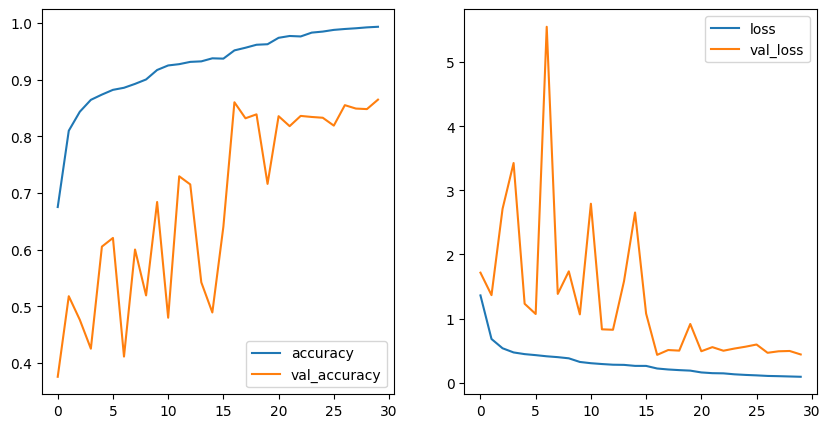

In [13]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label='val_accuracy')
axs[0].legend()

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label='val_loss')
axs[1].legend()
plt.show()

### Analyse Confusion Matrix

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Normalized confusion matrix
[[0.81437126 0.01497006 0.17065868]
 [0.02432046 0.97281831 0.00286123]
 [0.18101266 0.01898734 0.8       ]]


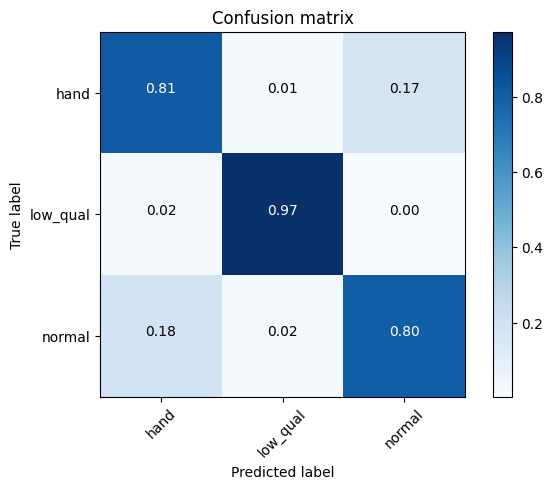

In [14]:
sys.path.append('./../')
from utils.phase_2 import plot_confusion_matrix

best_model = tf.keras.models.load_model('../models/phase_2/phase_2_model.keras')

p_test_best = best_model.predict(test_ds).argmax(axis=1)

true_labels_best = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

cm_best = confusion_matrix(true_labels_best, p_test_best)

plot_confusion_matrix(cm_best, CLASSES, normalize=True)